In [22]:
from pyspark.sql.functions import isnan, when, count, col, date_format
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, DoubleType
import datetime
from pyspark.sql.functions import expr
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from pyspark.sql import SparkSession, functions as F

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/22 20:28:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
# read taxi curated data
sdf = spark.read.parquet('../data/curated/*')

# Extract the day of the week
sdf_with_day = sdf.withColumn("day_of_week",\
                              date_format(col("tpep_pickup_datetime"), "E"))

# Create a new column that represents 1 for weekday and 0 for weekend
sdf_with_weekday = sdf_with_day.withColumn("is_weekday", \
                                            when(col("day_of_week") \
                                            .isin(["Sat", "Sun"]), 0) \
                                            .otherwise(1))
sdf_with_weekday.show(1, vertical=True)


-RECORD 0------------------------------------
 VendorID              | 1                   
 tpep_pickup_datetime  | 2022-08-01 00:17:39 
 tpep_dropoff_datetime | 2022-08-01 00:19:58 
 passenger_count       | 1                   
 trip_distance         | 0.4                 
 RatecodeID            | 1                   
 store_and_fwd_flag    | false               
 PULocationID          | 114                 
 DOLocationID          | 148                 
 payment_type          | 1                   
 fare_amount           | 3.5                 
 extra                 | 3.0                 
 mta_tax               | 0.5                 
 tip_amount            | 1.8                 
 tolls_amount          | 0.0                 
 improvement_surcharge | 0.3                 
 total_amount          | 9.1                 
 congestion_surcharge  | 2.5                 
 airport_fee           | 0.0                 
only showing top 1 row

-RECORD 0------------------------------------
 VendorID 

<Figure size 1000x600 with 0 Axes>

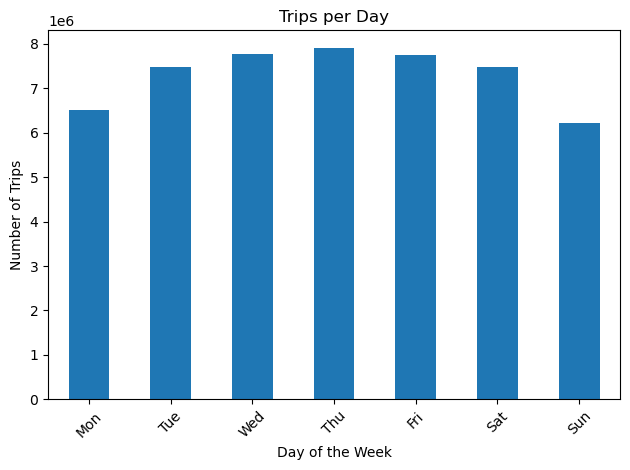

In [14]:
# Define the order for days of the week
day_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# Aggregate data by day_of_week
days_count = sdf_with_weekday.groupBy("day_of_week").count().toPandas()

# Convert the 'day_of_week' column to a categorical type with specified order
days_count['day_of_week'] = pd.Categorical(days_count['day_of_week'], \
                                           categories=day_order, ordered=True)

# Sort the dataframe by the 'day_of_week' column
days_count = days_count.sort_values('day_of_week')

# Plot
plt.figure(figsize=(10,6))
days_count.set_index("day_of_week").plot(kind='bar', legend=None)
plt.title("Trips per Day")
plt.ylabel("Number of Trips")
plt.xlabel("Day of the Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../plots/trips_per_day.png')
plt.show()

   is_weekday      count
0           1  7480978.6
1           0  6840157.0


<Figure size 400x600 with 0 Axes>

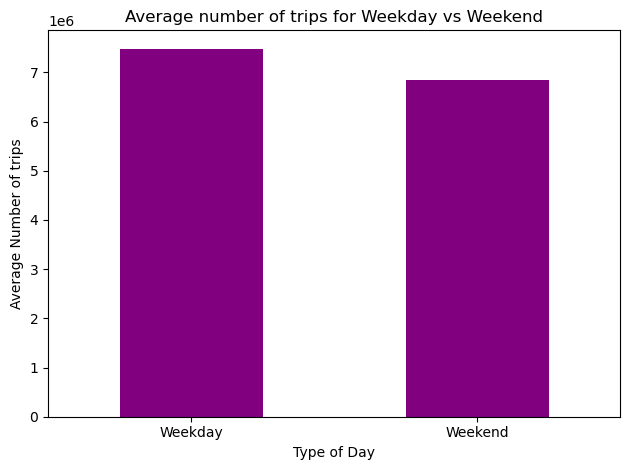

In [28]:
# we will plot a bar chart comparing avg number of trips during 
# weekend vs weekday

# Aggregate data by is_weekday
weekday_count = sdf_with_weekday.groupBy("is_weekday").count().toPandas()

# if is_weekday is 1, divide count by 5 and if not divide by 2 to get avg trips
weekday_count["count"] = np.where(weekday_count["is_weekday"] == 1, \
                                  weekday_count["count"]/5, \
                                    weekday_count["count"]/2)
print(weekday_count.head())

# Replace the numerical values with descriptive labels
weekday_count["is_weekday"] = weekday_count["is_weekday"] \
                            .replace({1: "Weekday", 0: "Weekend"})

# Plot
plt.figure(figsize=(4,6))
weekday_count.set_index("is_weekday").plot(kind='bar', color = 'purple', \
                                           legend=None)
plt.title("Average number of trips for Weekday vs Weekend")
plt.ylabel("Average Number of trips")
plt.xlabel("Type of Day")
plt.xticks(rotation=0)
plt.tight_layout()
# save figure
plt.savefig('../plots/trips_weekday_weekend.png')
plt.show()